# Градиентный бустинг своими руками

**Внимание:** в тексте задания произошли изменения - поменялось число деревьев (теперь 50), правило изменения величины шага в задании 3 и добавился параметр `random_state` у решающего дерева. Правильные ответы не поменялись, но теперь их проще получить. Также исправлена опечатка в функции `gbm_predict`.

В этом задании будет использоваться датасет `boston` из `sklearn.datasets`. Оставьте последние 25% объектов для контроля качества, разделив `X` и `y` на `X_train`, `y_train` и `X_test`, `y_test`.

Целью задания будет реализовать простой вариант градиентного бустинга над регрессионными деревьями для случая квадратичной функции потерь.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb

In [137]:
import sklearn

from sklearn import datasets, model_selection, tree, dummy, metrics, linear_model

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

In [5]:
import seaborn as sns
sns.set()

from scipy import optimize

## Задание 1

Как вы уже знаете из лекций, **бустинг** - это метод построения композиций базовых алгоритмов с помощью последовательного добавления к текущей композиции нового алгоритма с некоторым коэффициентом. 

Градиентный бустинг обучает каждый новый алгоритм так, чтобы он приближал антиградиент ошибки по ответам композиции на обучающей выборке. Аналогично минимизации функций методом градиентного спуска, в градиентном бустинге мы подправляем композицию, изменяя алгоритм в направлении антиградиента ошибки.

Воспользуйтесь формулой из лекций, задающей ответы на обучающей выборке, на которые нужно обучать новый алгоритм (фактически это лишь чуть более подробно расписанный градиент от ошибки), и получите частный ее случай, если функция потерь `L` - квадрат отклонения ответа композиции `a(x)` от правильного ответа `y` на данном `x`.

Если вы давно не считали производную самостоятельно, вам поможет таблица производных элементарных функций (которую несложно найти в интернете) и правило дифференцирования сложной функции. После дифференцирования квадрата у вас возникнет множитель 2 — т.к. нам все равно предстоит выбирать коэффициент, с которым будет добавлен новый базовый алгоритм, проигноируйте этот множитель при дальнейшем построении алгоритма.

In [12]:
data = datasets.load_boston()
X = data.data
y = data.target

In [7]:
df = pd.DataFrame(X, columns=data.feature_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
dtypes: float64(13)
memory usage: 51.5 KB


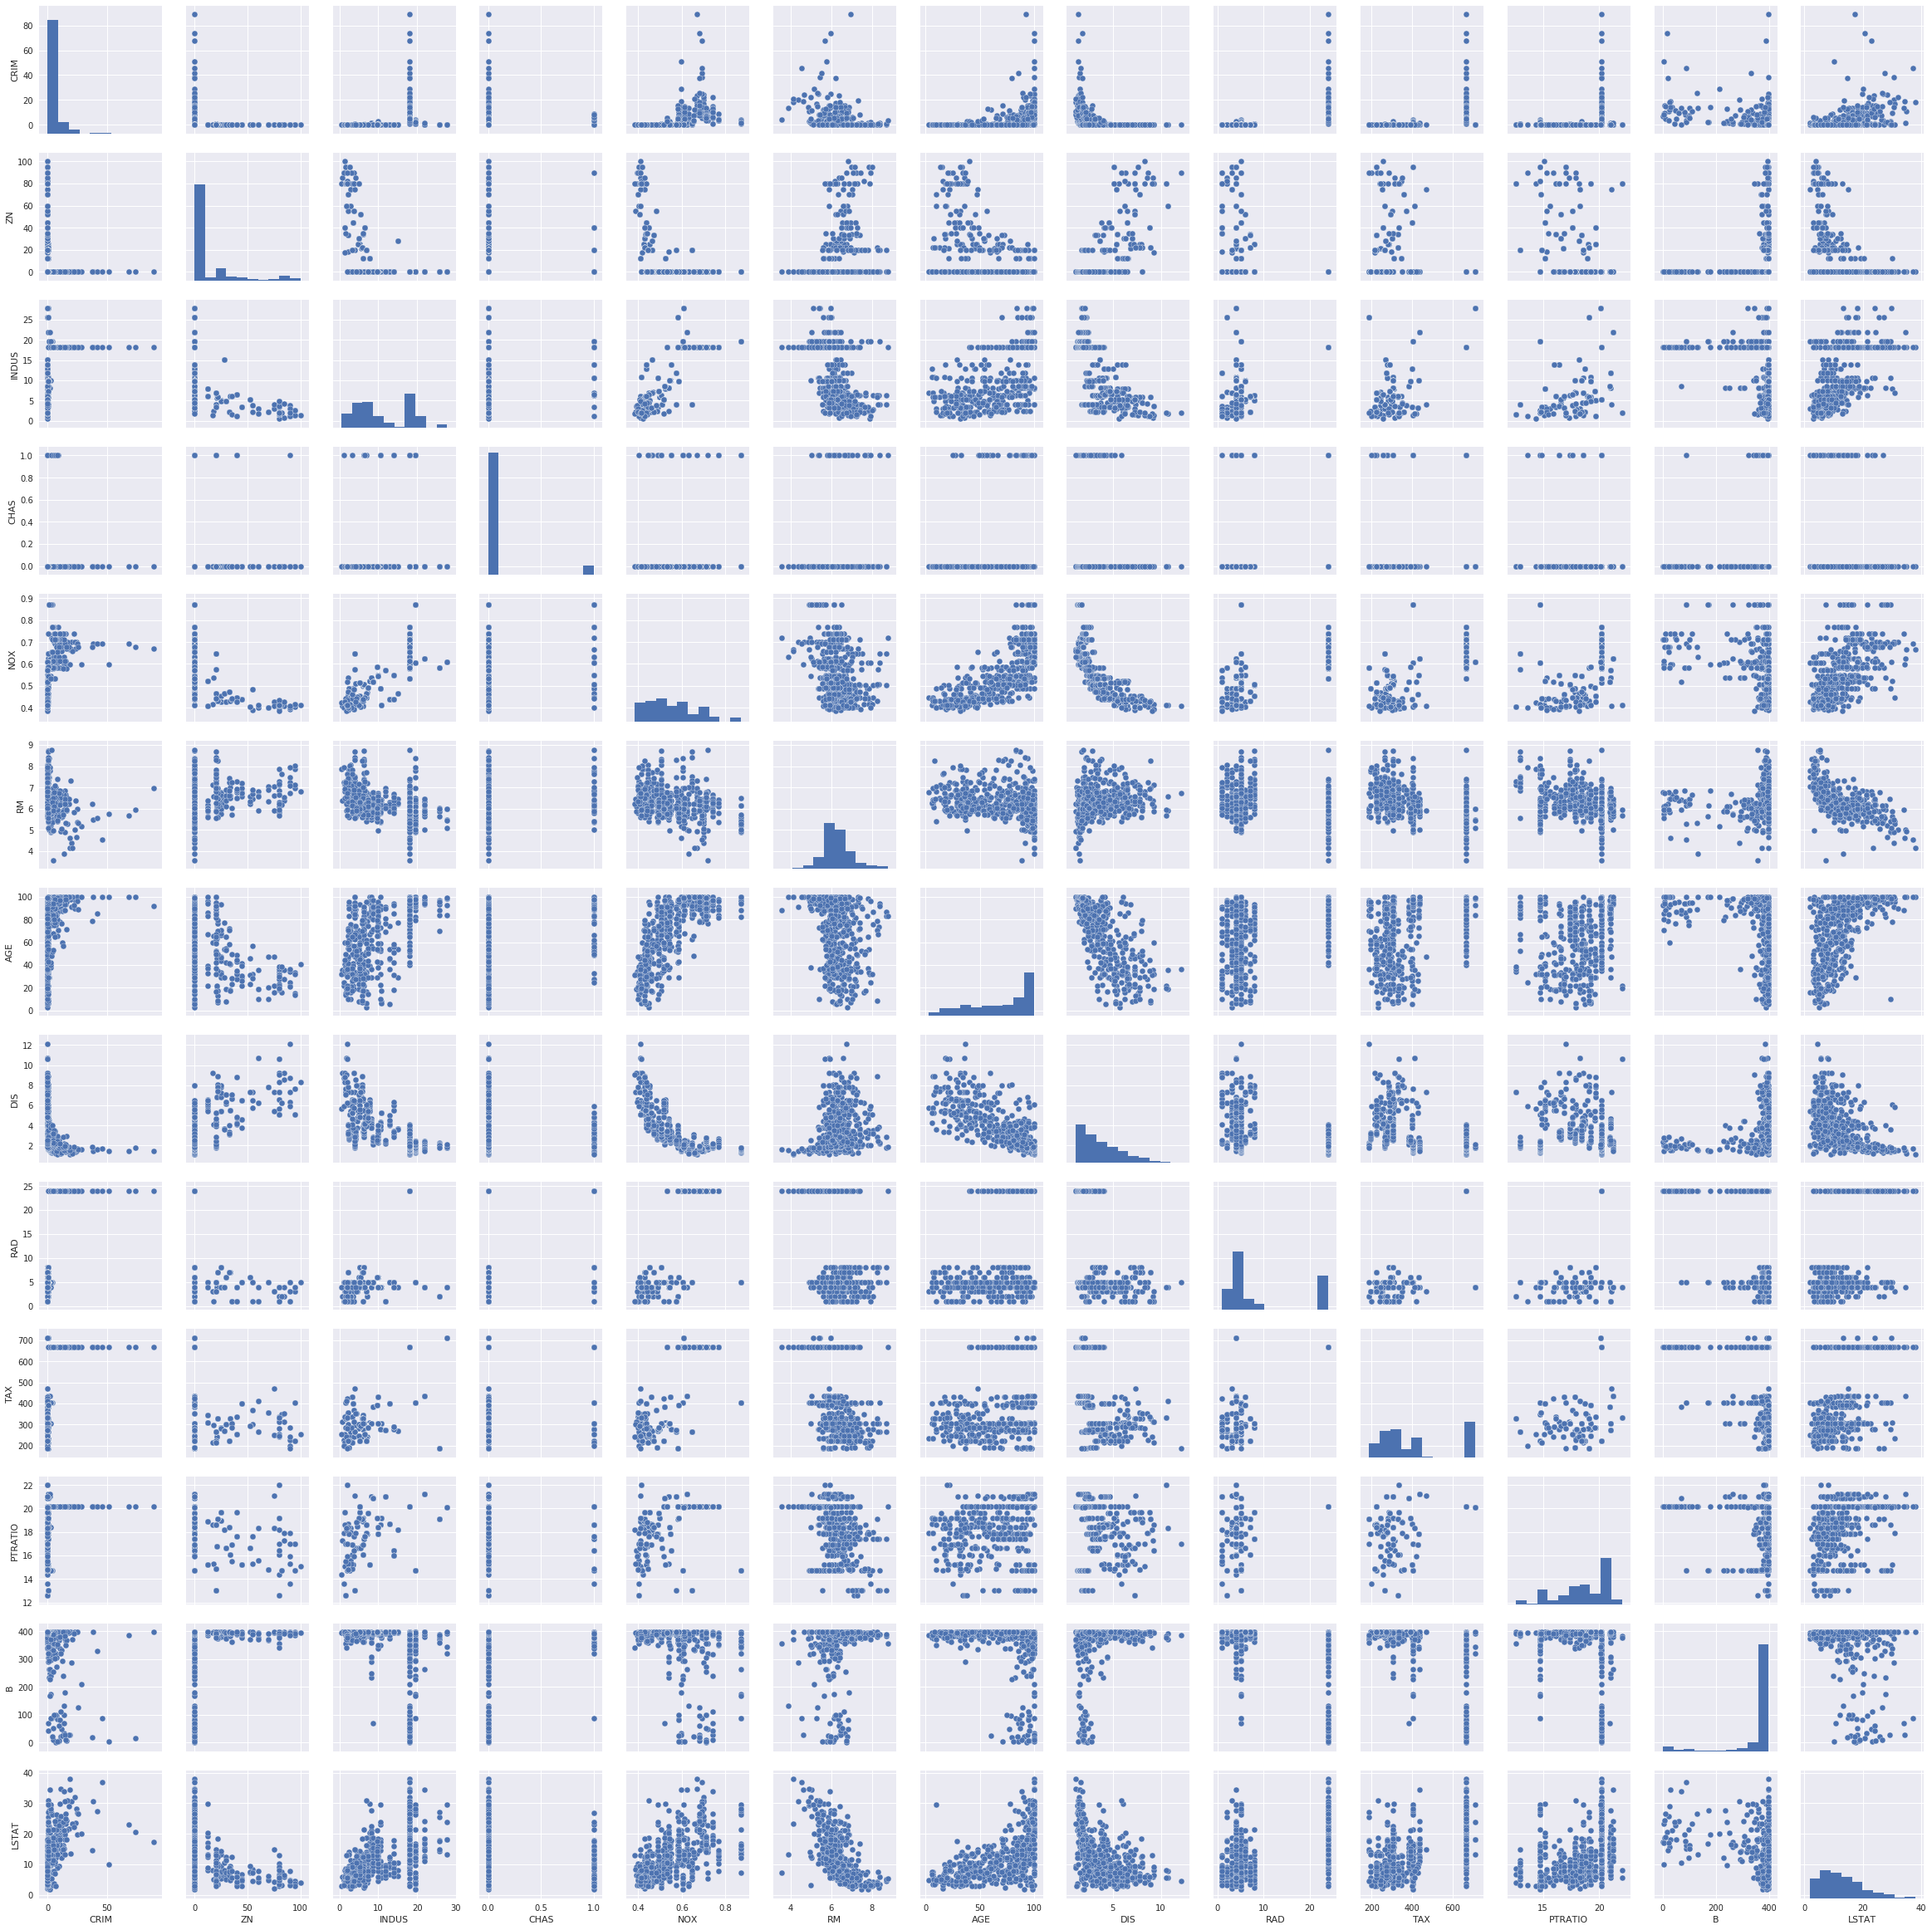

In [9]:
sns.pairplot(df)

/home/yuri/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


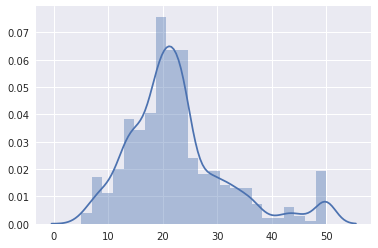

In [13]:
sns.distplot(y)

In [14]:
df.corrwith(pd.Series(y)).sort_values(ascending=False)

RM         0.695360
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
AGE       -0.376955
RAD       -0.381626
CRIM      -0.385832
NOX       -0.427321
TAX       -0.468536
INDUS     -0.483725
PTRATIO   -0.507787
LSTAT     -0.737663
dtype: float64

In [15]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, shuffle=False)

### Some benchmarks

In [24]:
linear_regressor = linear_model.LinearRegression().fit(X_train, y_train)
mean_squared_error(y_test, linear_regressor.predict(X_test))

68.40064151693524

In [25]:
lasso = linear_model.Lasso().fit(X_train, y_train)
mean_squared_error(y_test, lasso.predict(X_test))

41.849162161944506

In [26]:
lassocv = linear_model.LassoCV().fit(X_train, y_train)
mean_squared_error(y_test, lassocv.predict(X_test))

62.80287724490437

In [27]:
dummy = DummyRegressor().fit(X_train, y_train)
mean_squared_error(y_test, dummy.predict(X_test))

131.49210518436516

In [28]:
tree_reg = DecisionTreeRegressor(max_depth=5, random_state=42).fit(X_train, y_train)
mean_squared_error(y_test, tree_reg.predict(X_test))

23.742332541638085

In [29]:
rf_reg = RandomForestRegressor(n_estimators=2, max_depth=5, random_state=42).fit(X_train, y_train)
mean_squared_error(y_test, rf_reg.predict(X_test))

25.310689408244134

### Train functions

In [30]:
def gbm_predict(base_algorithms, coefficients, X):
    return np.array([sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms, coefficients)]) for x in X])

In [354]:
def plot_train_test_errors(train_error, test_error):
    with sns.axes_style("white"):
        fig, ax1 = plt.subplots()

        color = 'C0'
        ax1.semilogy(train_error, '*-', color=color, label='Train Error')    
        ax1.set_xlabel('n_estimators')
        ax1.set_ylabel('Train MSE', color=color )

        color = 'C1'
        ax2 = ax1.twinx()
        ax2.plot(test_error, '*-', color=color, label='Test Error')
        ax2.set_xlabel('n_estimators')
        ax2.set_ylabel('Test MSE', color=color)

        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc=5)

        fig.tight_layout()

In [157]:
def train_gbm(X_train, y_train, base_algorigthm,
              n_estimators=50, task='2'):
    
    base_algorithms = []
    coefficients = []
    test_errors = []
    train_errors = []

    for i in range(n_estimators):
        
        pred_train = gbm_predict(base_algorithms, coefficients, X_train)
        s = y_train - pred_train
        clf = sklearn.base.clone(base_algorigthm).fit(X_train, s)
        
        base_algorithms.append(clf)
        if task == '2':
            coefficients.append(0.9)
        elif task == '3':
            coefficients.append(0.9 / (1. + i))
        elif task == '3b':
            dpred_train = clf.predict(X_train)
            opt = optimize.minimize_scalar(lambda coef: mean_squared_error(y_train, pred_train + coef * dpred_train))
            coefficients.append(opt.x)
            
                

        train_errors.append(mean_squared_error(y_train, gbm_predict(base_algorithms, coefficients, X_train)))
        test_errors.append(mean_squared_error(y_test, gbm_predict(base_algorithms, coefficients, X_test)))
    
    return base_algorithms, coefficients, train_errors, test_errors 

In [413]:
def write_answer(file, answer):
    with open(file, 'w') as f:
        f.write(answer)

## Задание 2

Заведите массив для объектов `DecisionTreeRegressor` (будем их использовать в качестве базовых алгоритмов) и для вещественных чисел (это будут коэффициенты перед базовыми алгоритмами). 

В цикле от обучите последовательно 50 решающих деревьев с параметрами `max_depth=5` и `random_state=42` (остальные параметры - по умолчанию). В бустинге зачастую используются сотни и тысячи деревьев, но мы ограничимся 50, чтобы алгоритм работал быстрее, и его было проще отлаживать (т.к. цель задания разобраться, как работает метод). Каждое дерево должно обучаться на одном и том же множестве объектов, но ответы, которые учится прогнозировать дерево, будут меняться в соответствие с полученным в задании 1 правилом. 

Попробуйте для начала всегда брать коэффициент равным 0.9. Обычно оправдано выбирать коэффициент значительно меньшим - порядка 0.05 или 0.1, но т.к. в нашем учебном примере на стандартном датасете будет всего 50 деревьев, возьмем для начала шаг побольше.

В процессе реализации обучения вам потребуется функция, которая будет вычислять прогноз построенной на данный момент композиции деревьев на выборке `X`:

```
def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]
(считаем, что base_algorithms_list - список с базовыми алгоритмами, coefficients_list - список с коэффициентами перед алгоритмами)
```

Эта же функция поможет вам получить прогноз на контрольной выборке и оценить качество работы вашего алгоритма с помощью `mean_squared_error` в `sklearn.metrics`. 

Возведите результат в степень 0.5, чтобы получить `RMSE`. Полученное значение `RMSE` — **ответ в пункте 2**.

In [143]:
base_algorithms2, coefficients2, train_errors2, test_errors2 = \
    train_gbm(X_train, y_train, DecisionTreeRegressor(max_depth=5, random_state=42), n_estimators=50, task='2')

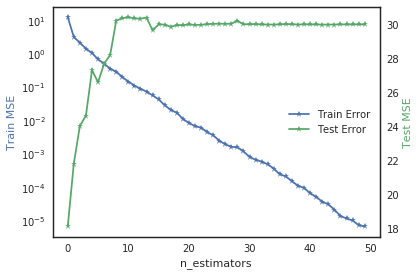

In [357]:
plot_train_test_errors(train_errors2, test_errors2)

In [145]:
print(test_error2[-1])

29.993705892865695


In [146]:
answer2 = np.sqrt(test_error2[-1])
print(answer2)

5.476650974168948


## Задание 3

Вас может также беспокоить, что двигаясь с постоянным шагом, вблизи минимума ошибки ответы на обучающей выборке меняются слишком резко, перескакивая через минимум. 

Попробуйте уменьшать вес перед каждым алгоритмом с каждой следующей итерацией по формуле `0.9 / (1.0 + i)`, где `i` - номер итерации (от 0 до 49). Используйте качество работы алгоритма как **ответ в пункте 3**. 

В реальности часто применяется следующая стратегия выбора шага: как только выбран алгоритм, подберем коэффициент перед ним численным методом оптимизации таким образом, чтобы отклонение от правильных ответов было минимальным. Мы не будем предлагать вам реализовать это для выполнения задания, но рекомендуем попробовать разобраться с такой стратегией и реализовать ее при случае для себя.

In [149]:
base_algorithms3, coefficients3, train_errors3, test_errors3 = \
    train_gbm(X_train, y_train, DecisionTreeRegressor(max_depth=5, random_state=42), n_estimators=50, task='3')

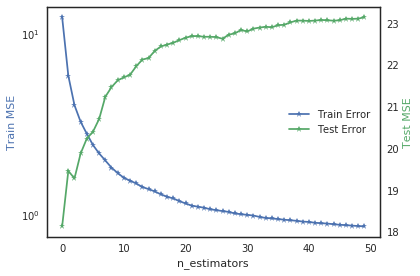

In [355]:
plot_train_test_errors(train_errors3, test_errors3)

In [151]:
test_errors3[-1]

23.14469415403693

In [152]:
answer3 = np.sqrt(test_errors3[-1])
print(answer3)

4.810893280258556


### with line search for the best coefficient

In [158]:
base_algorithms3b, coefficients3b, train_errors3b, test_errors3b = \
    train_gbm(X_train, y_train, DecisionTreeRegressor(max_depth=5, random_state=42), n_estimators=50, task='3b')

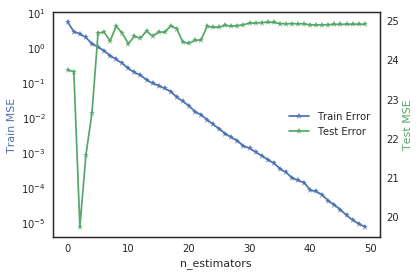

In [356]:
plot_train_test_errors(train_errors3b, test_errors3b)

In [160]:
test_errors3b[-1]

24.90895015525799

## Задание 4

Реализованный вами метод - градиентный бустинг над деревьями - очень популярен в машинном обучении. Он представлен как в самой библиотеке `sklearn`, так и в сторонней библиотеке `XGBoost`, которая имеет свой питоновский интерфейс. На практике `XGBoost` работает заметно лучше `GradientBoostingRegressor` из `sklearn`, но для этого задания вы можете использовать любую реализацию. 

Исследуйте, переобучается ли градиентный бустинг с ростом числа итераций (и подумайте, почему), а также с ростом глубины деревьев. На основе наблюдений выпишите через пробел номера правильных из приведенных ниже утверждений в порядке возрастания номера (это будет **ответ в п.4**):

    1. С увеличением числа деревьев, начиная с некоторого момента, качество работы градиентного бустинга не меняется существенно.

    2. С увеличением числа деревьев, начиная с некоторого момента, градиентный бустинг начинает переобучаться.

    3. С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга на тестовой выборке начинает ухудшаться.

    4. С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга перестает существенно изменяться

In [314]:
mse_scorer = metrics.make_scorer(mean_squared_error, greater_is_better=True)

In [379]:
def plot_validation_scores(train_scores, test_scores, param_range, param_name):
    fig, ax1 = plt.subplots()

    color = 'C0'
    ax1.semilogy(param_range, train_scores.mean(axis=1), '*-', color=color, label='Train Score')
    ax1.fill_between(param_range,
                 train_scores.mean(axis=1) + train_scores.std(axis=1),
                 train_scores.mean(axis=1) - train_scores.std(axis=1),
                 color=color, alpha=0.3)
    ax1.set_xlabel(param_name)
    ax1.set_ylabel('Train MSE', color=color, fontweight='bold')

    ax2 = ax1.twinx()    
    color = 'C1'
    ax2.plot(param_range, test_scores.mean(axis=1), '*-', color=color, label='Test Score')
    ax2.fill_between(param_range,
                 test_scores.mean(axis=1) + test_scores.std(axis=1),
                 test_scores.mean(axis=1) - test_scores.std(axis=1),
                 color=color, alpha=0.3)
    ax2.set_xlabel(param_name)
    ax2.set_ylabel('Test MSE', color=color, fontweight='bold')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc=5)

    fig.tight_layout()

#### n_estimators

In [372]:
est = xgb.XGBRegressor()
n_estimators_range = np.arange(25, 201, 25)

In [373]:
train_scores_n_est, test_scores_n_est = model_selection.validation_curve(
    est, X_train, y_train, param_name='n_estimators', param_range=n_estimators_range, scoring=mse_scorer, cv=3)

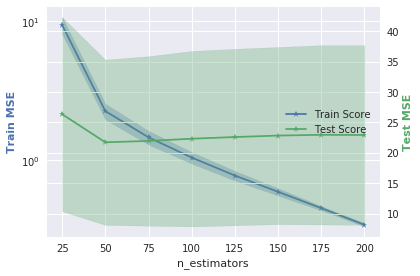

In [380]:
plot_validation_scores(train_scores_n_est, test_scores_n_est, n_estimators_range, 'n_estimators')

In [386]:
xgb_reg  = xgb.XGBRegressor(n_estimators=50).fit(X_train, y_train)

In [387]:
mean_squared_error(y_test, xgb_reg.predict(X_test))

26.368975831942144

#### max_depth

In [383]:
est = xgb.XGBRegressor()

max_depth_range = np.arange(2, 11)

In [384]:
train_scores_max_depth, test_scores_max_depth = model_selection.validation_curve(
    est, X_train, y_train, param_name='max_depth', param_range=max_depth_range, scoring=mse_scorer, cv=3)

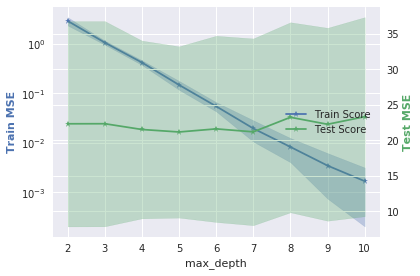

In [385]:
plot_validation_scores(train_scores_max_depth, test_scores_max_depth, max_depth_range, 'max_depth')

In [388]:
xgb_reg  = xgb.XGBRegressor(max_depth=5).fit(X_train, y_train)

In [389]:
mean_squared_error(y_test, xgb_reg.predict(X_test))

23.842264717606273

In [412]:
answer4 = "2 3"
write_answer('answer4.txt', answer4)

In [414]:
cat answer4.txt

2 3

#### grid cv

In [390]:
xgb_reg = xgb.XGBRegressor()

max_depth_range = np.arange(2, 11)
n_estimators_range = np.arange(25, 201, 25)

grid_cv = model_selection.GridSearchCV(xgb_reg,
                                       {'n_estimators': n_estimators_range, 'max_depth': max_depth_range},
                                       scoring='neg_mean_squared_error',
                                       return_train_score=True)

In [393]:
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([ 25,  50,  75, 100, 125, 150, 175, 200]), 'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [394]:
cv_results = pd.DataFrame(grid_cv.cv_results_)

In [395]:
cv_results[sorted(cv_results)]

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.006389,0.000548,-26.198863,-1.476434e+01,2,25,"{'max_depth': 2, 'n_estimators': 25}",64,-5.678764,-1.932800e+01,-28.928808,-1.510075e+01,-44.151873,-9.864259e+00,0.000767,0.000034,15.834452,3.870873e+00
1,0.009799,0.000543,-21.661372,-5.530783e+00,2,50,"{'max_depth': 2, 'n_estimators': 50}",28,-7.593750,-7.467627e+00,-16.915540,-5.352519e+00,-40.586475,-3.772204e+00,0.000643,0.000062,13.887888,1.513907e+00
2,0.012356,0.000542,-22.108627,-3.613014e+00,2,75,"{'max_depth': 2, 'n_estimators': 75}",33,-8.291262,-4.643132e+00,-16.587620,-3.364232e+00,-41.556659,-2.831679e+00,0.000377,0.000030,14.136904,7.601578e-01
3,0.014977,0.000539,-22.274427,-2.855113e+00,2,100,"{'max_depth': 2, 'n_estimators': 100}",40,-8.429158,-3.617266e+00,-16.250398,-2.541489e+00,-42.253609,-2.406583e+00,0.000100,0.000013,14.456956,5.417306e-01
4,0.018450,0.000635,-22.539319,-2.392864e+00,2,125,"{'max_depth': 2, 'n_estimators': 125}",42,-8.836799,-3.064530e+00,-15.999506,-2.105227e+00,-42.890403,-2.008836e+00,0.000184,0.000032,14.656967,4.765669e-01
5,0.023389,0.000740,-22.894925,-2.033037e+00,2,150,"{'max_depth': 2, 'n_estimators': 150}",45,-8.993059,-2.613401e+00,-16.437486,-1.764886e+00,-43.364563,-1.720826e+00,0.000553,0.000033,14.762235,4.107728e-01
6,0.026486,0.000775,-23.263329,-1.753991e+00,2,175,"{'max_depth': 2, 'n_estimators': 175}",57,-9.255171,-2.267015e+00,-16.538728,-1.490403e+00,-44.107263,-1.504555e+00,0.000161,0.000014,15.007645,3.628088e-01
7,0.029155,0.000847,-23.636317,-1.536739e+00,2,200,"{'max_depth': 2, 'n_estimators': 200}",63,-9.683180,-2.016874e+00,-16.547739,-1.262471e+00,-44.788773,-1.330873e+00,0.000477,0.000044,15.188577,3.406530e-01
8,0.005985,0.000347,-26.305938,-9.376994e+00,3,25,"{'max_depth': 3, 'n_estimators': 25}",66,-6.353819,-1.105212e+01,-27.243509,-9.200629e+00,-45.478836,-7.878231e+00,0.000178,0.000021,15.996818,1.301724e+00
9,0.010702,0.000409,-21.695346,-2.257360e+00,3,50,"{'max_depth': 3, 'n_estimators': 50}",30,-8.213507,-2.642659e+00,-16.621355,-2.191125e+00,-40.358176,-1.938296e+00,0.000064,0.000026,13.611010,2.913442e-01


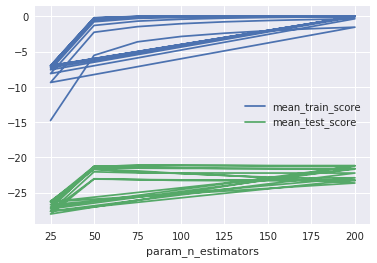

In [396]:
cv_results.plot(x='param_n_estimators', y=['mean_train_score', 'mean_test_score'])

In [398]:
grid_cv.best_params_

{'max_depth': 5, 'n_estimators': 125}

In [397]:
mean_squared_error(y_test, grid_cv.predict(X_test))

23.680558820367725

## Задание 5

Сравните получаемое с помощью градиентного бустинга качество с качеством работы линейной регрессии. 

Для этого обучите `LinearRegression` из `sklearn.linear_model` (с параметрами по умолчанию) на обучающей выборке и оцените для прогнозов полученного алгоритма на тестовой выборке `RMSE`. Полученное качество - ответ в **пункте 5**. 

В данном примере качество работы простой модели должно было оказаться хуже, но не стоит забывать, что так бывает не всегда. В заданиях к этому курсу вы еще встретите пример обратной ситуации.

In [ ]:
linear_regressor = linear_model.LinearRegression().fit(X_train, y_train)

In [415]:
lin_reg_mse = mean_squared_error(y_test, linear_regressor.predict(X_test))

In [416]:
np.sqrt(lin_reg_mse)

8.270468034938126